In [1]:
# Импорт библиотек
import os
import time
import cotel
import GTU
import mat_properties as prop
import numpy as n
import pandas as pd
from scipy.optimize import root

# Основные константы
calctolerance = 10**-3
calcmethod = "hybr"
KPDnasos = 0.8074
KPD = 0.99

# таблица номинального режима
gas_streams0 = pd.read_excel("streams0.xlsx", sheet_name="gas", index_col=0)
water_streams0 = pd.read_excel(
    "streams0.xlsx", sheet_name="water", index_col=0)
GTU_ISO = pd.read_excel("input.xlsx", sheet_name="ISO", index_col=0)
# таблица задаваемых значений (заменится на интерфейс)
gas_streamsINPUT = pd.read_excel("streams.xlsx", sheet_name="gas", index_col=0)
water_streamsINPUT = pd.read_excel("streams.xlsx", sheet_name="water", index_col=0)
GTU_input = pd.read_excel("input.xlsx", sheet_name="GTU_input", index_col=0)
# рабочая таблица (=номинал в 1 итерации)
gas_streams = gas_streams0.copy()
water_streams = water_streams0.copy()
# рабочая таблица показателей блоков
heaters = pd.read_excel("blocks.xlsx", sheet_name="heaters", index_col=0)
electric = pd.read_excel("blocks.xlsx", sheet_name="electric", index_col=0)


# Состав газов в номинале
gasmix = "Nitrogen*Oxygen*CO2*Water*Argon"
# Считывание рефпропа
RP = prop.init_REFPROP(r"C:\Program Files (x86)\REFPROP")
fractiongas0 = (
    gas_streams0.at["GTU-PEVD", "N2"],
    gas_streams0.at["GTU-PEVD", "O2"],
    gas_streams0.at["GTU-PEVD", "CO2"],
    gas_streams0.at["GTU-PEVD", "H2O"],
    gas_streams0.at["GTU-PEVD", "Ar"],
)

gas0 = prop.Materials_prop(
    gasmix,
    fractiongas0,
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    RP=RP,
)
water = prop.Materials_prop(
    "water",
    [1.0, 0, 0, 0, 0],
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    RP=RP,
)


# Задание энтальпий газа в номинальном режиме
Temperatures = gas_streams0.loc["GTU-KU":"GPK-out", "T"]
Pressure= gas_streams0.loc["GTU-KU", "P"]
Enthalpies = list(map(lambda x: gas0.p_t(Pressure, x)["h"], Temperatures))
gas_streams0.loc["GTU-KU":"GPK-out", "H"] = Enthalpies


####################################################################################################
# Расчет ГТУ
Gas_turbine = GTU.gtu(GTU_ISO, GTU_input, "GTU-KU")
Gas_turbine_res = Gas_turbine.calc()
electric.loc["GTU", "N"] = Gas_turbine_res["N"]
electric.loc["GTU", "KPD"] = Gas_turbine_res["eff"]
electric.loc["DK", "N"] = Gas_turbine_res["Ndk"]
gas_streams = pd.read_excel("streams.xlsx", sheet_name="gas", index_col=0)
gas_streams.loc["GTU-KU", "T"] = Gas_turbine_res["T"]
gas_streams.loc["GTU-KU", "G"] = Gas_turbine_res["G"]
gas_streams.loc["GTU-KU", "P"] = 0.1
Gas_turbine_composition=pd.read_excel("input.xlsx", sheet_name="Gas_composition0", index_col=0)

# чтение с вводного экселя входных данных
Pvd = water_streamsINPUT.loc["PEVD-DROSVD", "P"]
Pnd = water_streamsINPUT.loc["PPND-DROSND", "P"]
Twat0 = water_streams0.loc["REC-GPK", "T"]

#Параметры газа на выходе в КУ
gas_streams.loc["GTU-PEVD", "T":"P"] = gas_streams.loc["GTU-KU", "T":"P"]
gas_streams.loc["GTU-PEVD", "G"] = gas_streams.loc["GTU-KU", "G"]
gas_streams.loc["GTU-PEVD", "N2":"Ar"]=Gas_turbine_composition.loc["Fraction", "N2":"Ar"]

# Состав газов при частичной нагрузке
fractiongas = (
    gas_streams.at["GTU-PEVD", "N2"],
    gas_streams.at["GTU-PEVD", "O2"],
    gas_streams.at["GTU-PEVD", "CO2"],
    gas_streams.at["GTU-PEVD", "H2O"],
    gas_streams.at["GTU-PEVD", "Ar"],
)
gas1 = prop.Materials_prop(
    gasmix,
    fractiongas,
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    RP=RP,
)

# Задание энтальпий газа в рабочем режиме
Temperatures = gas_streams.loc["GTU-KU":"GPK-out", "T"]
Pressure= gas_streams.loc["GTU-KU", "P"]
Enthalpies = list(map(lambda x: gas1.p_t(Pressure, x)["h"], Temperatures))
gas_streams.loc["GTU-KU":"GPK-out", "H"] = Enthalpies

# Задание в раб табл параметров по воде
water_streams.loc["PEVD-DROSVD", "T"] = Pvd
water_streams.loc["PPND-DROSND", "T"] = Pnd
water_streams.loc["REC-GPK", "T"] = Twat0

# Расчёт параметров на насыщении в испарительных поверхностях (в 1 итерации приближение: недогрев до н.п. на входе 3°С)
water_streams.loc["IVD-PEVD", "T"] = water.p_q(Pvd, 1)["T"]
water_streams.loc["IVD-PEVD", "H"] = water.p_q(Pvd, 1)["h"]
water_streams.loc["IND-PPND", "T"] = water.p_q(Pnd, 1)["T"]
water_streams.loc["IND-PPND", "H"] = water.p_q(Pnd, 1)["h"]
water_streams.loc["EVD-IVD", "T"] = water.p_q(Pvd, 1)["T"] - 3
water_streams.loc["GPK-IND", "T"] = water.p_q(Pnd, 1)["T"] - 3
water_streams.loc["EVD-IVD", "H"] = water.p_t(Pvd, water_streams.loc["EVD-IVD", "T"])["h"]
water_streams.loc["GPK-IND", "H"] = water.p_t(Pnd, water_streams.loc["GPK-IND", "T"])["h"]

####################################################################################################
# расчет котла целиком
Whole_cotel = cotel.cotel_all(
    KPD,
    KPDnasos,
    calctolerance*10**1,
    gas0,
    gas1,
    water,
    calcmethod,
    gas_streams0,
    water_streams0,
    gas_streams,
    water_streams,
    heaters,
    electric
)
Whole_cotel.calc(maxiterations=50)


Whole_cotel = cotel.cotel_all(
    KPD,
    KPDnasos,
    calctolerance,
    gas0,
    gas1,
    water,
    calcmethod,
    gas_streams0,
    water_streams0,
    gas_streams,
    water_streams,
    heaters,
    electric
)
Whole_cotel.calc(maxiterations=50)


print(
    "Степень сухости пара в ЭВД: ",
    water.p_h(water_streams.at["EVD-IVD", "P"],
              water_streams.at["EVD-IVD", "H"])["Q"],
)
print(
    "Степень сухости пара в ГПК: ",
    water.p_h(water_streams.at["GPK-IND", "P"],
              water_streams.at["GPK-IND", "H"])["Q"],
)

Prop:--- 0.01 сек. ---
Iter:--- 0.12 сек. ---
Else:--- 0.0 сек. ---
PEVD:--- 0.14 сек. ---
IVD:--- 0.18 сек. ---
Prop:--- 0.02 сек. ---
Iter:--- 0.14 сек. ---
Else:--- 0.02 сек. ---
EVD:--- 0.17 сек. ---
dQ/Q ПЕВД+ИВД+ЭВД 1.7866554593325348
Prop:--- 0.0 сек. ---
Iter:--- 0.11 сек. ---
Else:--- 0.02 сек. ---
PEVD:--- 0.13 сек. ---
IVD:--- 0.17 сек. ---
Prop:--- 0.03 сек. ---
Iter:--- 0.14 сек. ---
Else:--- 0.0 сек. ---
EVD:--- 0.18 сек. ---
dQ/Q ПЕВД+ИВД+ЭВД -0.9948064132023087
Prop:--- 0.01 сек. ---
Iter:--- 0.12 сек. ---
Else:--- 0.0 сек. ---
PEVD:--- 0.14 сек. ---
IVD:--- 0.2 сек. ---
Prop:--- 0.01 сек. ---
Iter:--- 0.15 сек. ---
Else:--- 0.0 сек. ---
EVD:--- 0.17 сек. ---
dQ/Q ПЕВД+ИВД+ЭВД 0.48970633078738324
Prop:--- 0.01 сек. ---
Iter:--- 0.12 сек. ---
Else:--- 0.0 сек. ---
PEVD:--- 0.13 сек. ---
IVD:--- 0.19 сек. ---
Prop:--- 0.02 сек. ---
Iter:--- 0.14 сек. ---
Else:--- 0.0 сек. ---
EVD:--- 0.16 сек. ---
dQ/Q ПЕВД+ИВД+ЭВД -0.2489658722825728
Prop:--- 0.02 сек. ---
Iter:--- 0.12 

IVD:--- 0.21 сек. ---
Prop:--- 0.01 сек. ---
Iter:--- 0.17 сек. ---
Else:--- 0.0 сек. ---
EVD:--- 0.19 сек. ---
dQ/Q ПЕВД+ИВД+ЭВД -0.0019667443339924833
Prop:--- 0.01 сек. ---
Iter:--- 0.14 сек. ---
Else:--- 0.0 сек. ---
PEVD:--- 0.15 сек. ---
IVD:--- 0.22 сек. ---
Prop:--- 0.01 сек. ---
Iter:--- 0.17 сек. ---
Else:--- 0.0 сек. ---
EVD:--- 0.19 сек. ---
dQ/Q ПЕВД+ИВД+ЭВД -0.005008493677020083
Prop:--- 0.01 сек. ---
Iter:--- 0.14 сек. ---
Else:--- 0.0 сек. ---
PEVD:--- 0.15 сек. ---
IVD:--- 0.22 сек. ---
Prop:--- 0.01 сек. ---
Iter:--- 0.17 сек. ---
Else:--- 0.0 сек. ---
EVD:--- 0.19 сек. ---
dQ/Q ПЕВД+ИВД+ЭВД 0.009181988213700774
Prop:--- 0.01 сек. ---
Iter:--- 0.14 сек. ---
Else:--- 0.0 сек. ---
PEVD:--- 0.15 сек. ---
IVD:--- 0.22 сек. ---
Prop:--- 0.01 сек. ---
Iter:--- 0.17 сек. ---
Else:--- 0.0 сек. ---
EVD:--- 0.19 сек. ---
dQ/Q ПЕВД+ИВД+ЭВД -0.011233847897127131
Prop:--- 0.01 сек. ---
Iter:--- 0.14 сек. ---
Else:--- 0.0 сек. ---
PEVD:--- 0.15 сек. ---
IVD:--- 0.22 сек. ---
Prop:-

In [2]:
# Вывод газовых потоков
gas_streams

,T,P,H,G,N2,O2,CO2,H2O,Ar
GTU-KU,542.010558,0.1,958.533980,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
GTU-PEVD,542.010558,0.1,958.533980,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
PEVD-IVD,467.904295,0.1,873.866774,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
IVD-EVD,309.116188,0.1,697.325870,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
EVD-PPND,236.156771,0.1,618.354569,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
PPND-IND,233.254885,0.1,615.238956,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
IND-GPK,175.519715,0.1,553.615486,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
GPK-out,103.186666,0.1,477.254325,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065


In [3]:
# Вывод водяных потоков
water_streams

,T,P,H,G,S
PEVD-DROSVD,511.338528,8.407000,3422.809527,62.471401,NaN
IVD-PEVD,301.220693,8.736573,2747.256370,62.471401,NaN
EVD-IVD,298.917844,8.736573,1338.631351,62.471401,NaN
PEN-EVD,166.546357,8.736573,708.515006,62.471401,NaN
BND-PEN,164.720119,0.696085,696.016032,62.471401,NaN
PPND-DROSND,211.367391,0.691000,2870.969978,14.320001,NaN
IND-PPND,164.720119,0.696085,2762.515837,14.320001,NaN
GPK-IND,161.349662,0.696085,681.372552,76.791402,NaN
GPK-REC,161.349662,0.696085,681.372552,88.596380,NaN
REC-GPK,60.000000,0.696085,251.748131,88.596896,NaN


In [4]:
water_streams0['PEVD-DROSVD':'REC-GPK']

,T,P,H,G,S
PEVD-DROSVD,511.500000,8.4070,3423.209978,63.40,NaN
IVD-PEVD,301.297556,8.7460,2747.104023,63.40,NaN
EVD-IVD,298.800000,8.7460,1337.948265,63.40,NaN
PEN-EVD,166.500000,8.7460,708.319849,63.40,NaN
BND-PEN,164.738361,0.6964,696.095567,63.40,NaN
PPND-DROSND,211.600000,0.6910,2871.481837,14.76,NaN
IND-PPND,164.738361,0.6964,2762.534980,14.76,NaN
GPK-IND,164.600000,0.6964,695.493701,78.16,NaN
GPK-REC,164.600000,0.6964,695.493701,82.91,NaN
REC-GPK,60.000000,0.6964,251.748396,82.91,NaN


In [5]:
Errors_water= abs(water_streams.loc['PEVD-DROSVD':'REC-GPK','T':'G'] -water_streams0.loc['PEVD-DROSVD':'REC-GPK','T':'G'])/water_streams0.loc['PEVD-DROSVD':'REC-GPK','T':'G']*100
Errors_water

,T,P,H,G
PEVD-DROSVD,0.031568,0.000000,0.011698,1.464668
IVD-PEVD,0.025511,0.107785,0.005546,1.464668
EVD-IVD,0.039439,0.107785,0.051055,1.464668
PEN-EVD,0.027842,0.107785,0.027552,1.464668
BND-PEN,0.011074,0.045273,0.011426,1.464668
PPND-DROSND,0.109929,0.000000,0.017826,2.981023
IND-PPND,0.011074,0.045273,0.000693,2.981023
GPK-IND,1.974689,0.045273,2.030378,1.751021
GPK-REC,1.974689,0.045273,2.030378,6.858498
REC-GPK,0.000000,0.045273,0.000105,6.859119


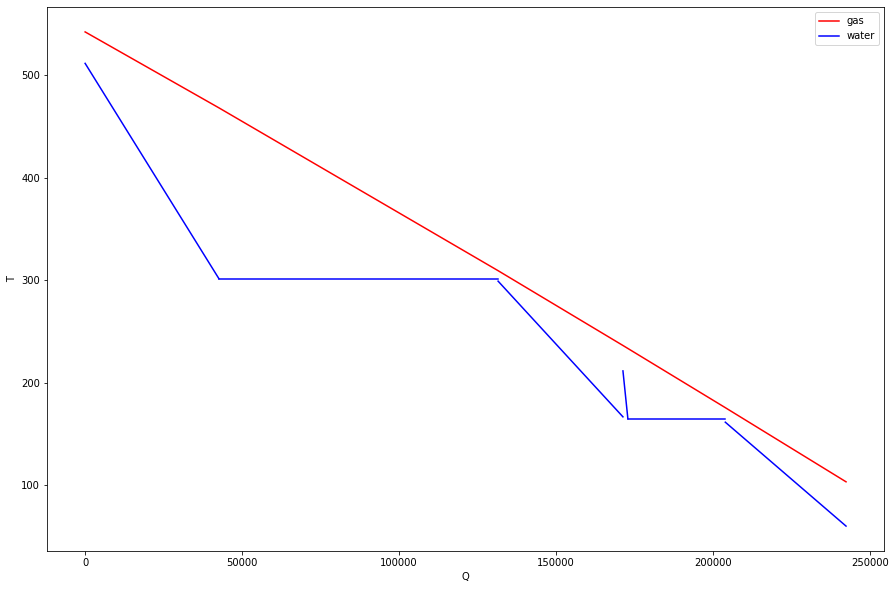

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
Qg =[0,
    heaters.loc['PEVD','Qg'],
    heaters.loc['PEVD','Qg']+heaters.loc['IVD','Qg'],
    heaters.loc['PEVD','Qg']+heaters.loc['IVD','Qg']+heaters.loc['EVD','Qg'],
    heaters.loc['PEVD','Qg']+heaters.loc['IVD','Qg']+heaters.loc['EVD','Qg']+heaters.loc['PPND','Qg'],
    heaters.loc['PEVD','Qg']+heaters.loc['IVD','Qg']+heaters.loc['EVD','Qg']+heaters.loc['PPND','Qg']+heaters.loc['IND','Qg'],
    heaters.loc['PEVD','Qg']+heaters.loc['IVD','Qg']+heaters.loc['EVD','Qg']+heaters.loc['PPND','Qg']+heaters.loc['IND','Qg']+heaters.loc['GPK','Qg']
    ]
Qw =[0,
    heaters.loc['PEVD','Qg'],
    heaters.loc['PEVD','Qg']+heaters.loc['IVD','Qg'],
    heaters.loc['PEVD','Qg']+heaters.loc['IVD','Qg'],
    heaters.loc['PEVD','Qg']+heaters.loc['IVD','Qg']+heaters.loc['EVD','Qg'],
    heaters.loc['PEVD','Qg']+heaters.loc['IVD','Qg']+heaters.loc['EVD','Qg'],
    heaters.loc['PEVD','Qg']+heaters.loc['IVD','Qg']+heaters.loc['EVD','Qg']+heaters.loc['PPND','Qg'],
    heaters.loc['PEVD','Qg']+heaters.loc['IVD','Qg']+heaters.loc['EVD','Qg']+heaters.loc['PPND','Qg']+heaters.loc['IND','Qg'],
    heaters.loc['PEVD','Qg']+heaters.loc['IVD','Qg']+heaters.loc['EVD','Qg']+heaters.loc['PPND','Qg']+heaters.loc['IND','Qg'],
    heaters.loc['PEVD','Qg']+heaters.loc['IVD','Qg']+heaters.loc['EVD','Qg']+heaters.loc['PPND','Qg']+heaters.loc['IND','Qg']+heaters.loc['GPK','Qg']
    ]
Tg = gas_streams.loc['GTU-PEVD':'GPK-out','T']
Tw = [water_streams.loc['PEVD-DROSVD','T'],
      water_streams.loc['IVD-PEVD','T'],
      water_streams.loc['IVD-PEVD','T'],
      water_streams.loc['EVD-IVD','T'],
      water_streams.loc['PEN-EVD','T'],
      water_streams.loc['PPND-DROSND','T'],
      water_streams.loc['IND-PPND','T'],
      water_streams.loc['IND-PPND','T'],
      water_streams.loc['GPK-REC','T'],
      water_streams.loc['REC-GPK','T'],
     ]
plt.plot(Qg,Tg, color = 'red')
plt.plot(Qw[0:2],Tw[0:2], color = 'blue')
plt.plot(Qw[1:3],Tw[1:3], color = 'blue')
plt.plot(Qw[3:5],Tw[3:5], color = 'blue')
plt.plot(Qw[5:7],Tw[5:7], color = 'blue')
plt.plot(Qw[6:8],Tw[6:8], color = 'blue')
plt.plot(Qw[8:10],Tw[8:10], color = 'blue')
plt.xlabel('Q')
plt.ylabel('T')
plt.legend(['gas','water'])
plt.show()